In [14]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

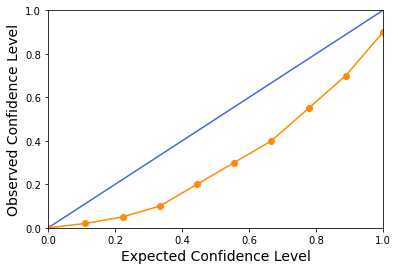

In [2]:
from training.regresssion import plot_calibration

class FakeResults:
    pass
results = FakeResults()
results.quantile_ps = torch.linspace(0, 1, 10)

# Underconfident
#results.observed_cdf = torch.tensor([0.05, 0.3, 0.5, 0.65, 0.75, 0.82, 0.88, 0.94, 0.98, 1])

# Overconfident
results.observed_cdf = torch.tensor([0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.55, 0.7, 0.9])

# Overconfident Quantile
#results.observed_cdf = torch.tensor([0.8, 0.77, 0.72, 0.65, 0.55, 0.45, 0.4, 0.35, 0.34, 0.33])

plot_calibration(None, results, plt.subplot(), include_text=False)
plt.savefig("results/figs/overconfident_regression.pdf")

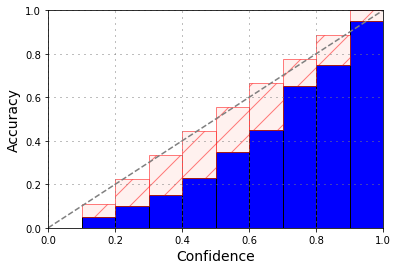

In [24]:
from training.calibration import reliability_diagram

# Underconfident
accuracies = torch.tensor([0, 0.05, 0.1, 0.15, 0.23, 0.35, 0.45, 0.65, 0.75, 0.95])

# Overconfident
#accuracies = torch.tensor([0.05, 0.2, 0.35, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1])

reliability_diagram(10, accuracies, torch.linspace(0, 1, 10), plt.subplot(), False, False, False, False, False)
plt.savefig("results/figs/overconfident_classification.pdf")

In [105]:
from training.spline import interpolate
from experiments.toy_regression import gap_datasets, NOISE, plot_grid
from scipy.interpolate import CubicSpline
from training.regresssion import normalize, denormalize

device = torch.device("cpu")

dataset, dataloader, testset = gap_datasets(device)

def create_splines(outside_std, gap_std):
    def spline_infer(x, samples):
        x = denormalize(x, dataset.x_mean, dataset.x_std)

        t = torch.cat((torch.linspace(0, 0.13, 10), torch.linspace(0.4, 0.55, 10)))
        output = []
        for _ in range(samples):
            xs = torch.cat((t, torch.tensor([-0.4, 0.9, 0.23])))
            left_y = torch.normal(torch.tensor(-1.0), torch.tensor(outside_std))
            right_y = torch.normal(torch.tensor(1.0), torch.tensor(outside_std))
            gap_y = torch.normal(torch.tensor(0.6), torch.tensor(gap_std))
            ys = torch.cat((dataset.eval(t, torch.tensor(0)), torch.tensor([left_y, right_y, gap_y])))
            xs, sort_indices = torch.sort(xs)
            ys = ys[sort_indices]
            spline = CubicSpline(xs, ys, bc_type="natural")
            output.append(torch.from_numpy(spline(x)))

        output = torch.stack(output)
        output = normalize(output, dataset.y_mean, dataset.y_std)
        return torch.stack((output, NOISE.expand(output.shape) / dataset.y_std), dim=-1)

    return spline_infer
    
#dataset.plot_predictions(-0.3, 0.8, create_splines(0.5, 0.2), 100, plt.subplot(), plot_ground_truth=True, alpha=0.3)
#plt.scatter([-0.4, 0.9, 0.23], [-1.0, 1.0, 0.6])

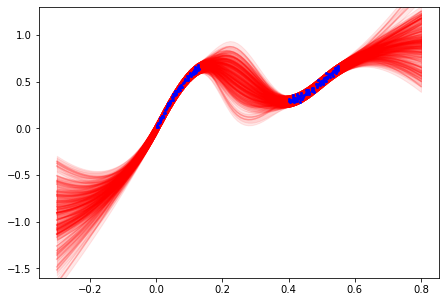

In [117]:
dataset.plot_predictions(-0.3, 0.8, create_splines(0.5, 0.15), 50, plt.subplot(), plot_ground_truth=False, alpha=0.3)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/good_epistemic.pdf")

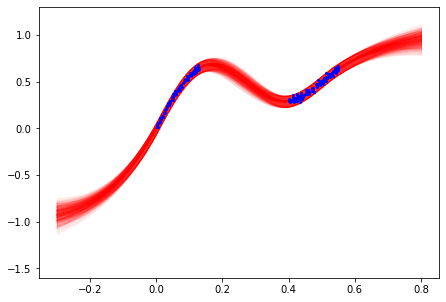

In [115]:
dataset.plot_predictions(-0.3, 0.8, create_splines(0.1, 0.03), 50, plt.subplot(), plot_ground_truth=False, alpha=0.1)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/narrow_epistemic.pdf")

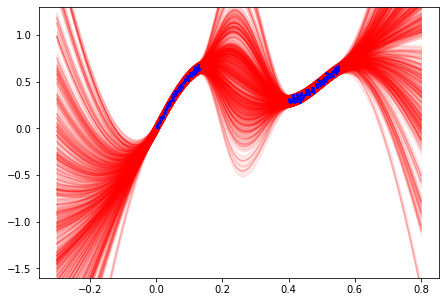

In [116]:
dataset.plot_predictions(-0.3, 0.8, create_splines(2.0, 0.4), 100, plt.subplot(), plot_ground_truth=False, alpha=0.3)
plt.ylim(-1.6, 1.3)
plt.tight_layout(pad=0)
plt.savefig("results/figs/wide_epistemic.pdf")

In [6]:
import os
from experiments.uci.results import UCIResults

all_results = {}

os.chdir("c:/Uni/Bachelor/results/UCI_GAP/results")
for method in os.listdir("."):
    if not os.path.isdir(method):
        continue
    print(method)
    os.chdir(method)
    
    for dataset in os.listdir("."):
        if not os.path.isdir(dataset):
            continue
        name = dataset.split('__')[1][1:]
        if name not in all_results:
            all_results[name] = {}
        print(f"  {name}")

        results = []
        for file in os.listdir(dataset + "/log"):
            if not file.endswith(".pyc"):
                continue
            results.append(UCIResults.load(dataset + "/log/" + file))
        all_results[name][method] = results
    os.chdir("..")

Ensemble-5
  concrete
  energy
  housing
  power
  wine
  yacht
MAP
  concrete
  energy
  housing
  power
  wine
  yacht
MCDropout
  concrete
  energy
  housing
  power
  wine
  yacht
MultiMCDropout
  concrete
  energy
  housing
  power
  wine
  yacht
MultiSWAG
  concrete
  energy
  housing
  power
  wine
  yacht
slurmlog
SWAG
  concrete
  energy
  housing
  power
  wine
  yacht


In [15]:
import numpy as np

def print_method(method, method_results):
    times = []
    lml = []
    mean_mse = []
    mse_of_means = []
    qce = []
    for rep in method_results:
        times.append(rep.time)
        lml.append(rep.results.average_lml)
        mean_mse.append(rep.results.mean_mse)
        mse_of_means.append(rep.results.mse_of_means)
        qce.append(rep.results.qce)
    times = torch.tensor(times)
    lml = torch.tensor(lml)
    mean_mse = torch.tensor(mean_mse)
    mse_of_means = torch.tensor(mse_of_means)
    qce = torch.tensor(qce)

    print((f"            & {method}"
        f" & ${lml.mean():.2f} \\pm {lml.std() / np.sqrt(len(lml)):.2f}$"
        #f" & ${mean_mse.mean():.2f} \\pm {mean_mse.std() / np.sqrt(len(mean_mse)):.2f}$"
        f" & ${mse_of_means.mean():.2f} \\pm {mse_of_means.std() / np.sqrt(len(mse_of_means)):.2f}$"
        f" & ${qce.mean():.2f} \\pm {qce.std() / np.sqrt(len(qce)):.2f}$"
        #f" & ${times.mean():.2f} \\pm {times.std() / np.sqrt(len(times)):.2f}$"
        " \\\\"
    ))

def print_dataset(dataset, dataset_results):
    print("        \\midrule")
    print("        \\multirow{" + str(len(dataset_results)) + "}{*}{" + dataset + "}")
    print_method("MAP", dataset_results["MAP"])
    print_method("Ensemble-5", dataset_results["Ensemble-5"])
    print_method("MCD", dataset_results["MCDropout"])
    print_method("MultiMCD-5", dataset_results["MultiMCDropout"])
    print_method("SWAG", dataset_results["SWAG"])
    print_method("MultiSWAG-5", dataset_results["MultiSWAG"])

print_dataset("Housing", all_results["housing"])
print_dataset("Concrete", all_results["concrete"])
print_dataset("Energy", all_results["energy"])
print_dataset("Wine", all_results["wine"])
print_dataset("Yacht", all_results["yacht"])
print_dataset("Power", all_results["power"])

        \midrule
        \multirow{6}{*}{Housing}
            & MAP & $-4.23 \pm 0.09$ & $14.71 \pm 0.47$ & $0.17 \pm 0.00$ \\
            & Ensemble-5 & $-3.82 \pm 0.06$ & $12.83 \pm 0.35$ & $0.12 \pm 0.00$ \\
            & MCD & $-2.77 \pm 0.02$ & $14.41 \pm 0.54$ & $0.07 \pm 0.00$ \\
            & MultiMCD-5 & $-2.73 \pm 0.02$ & $12.58 \pm 0.42$ & $0.05 \pm 0.00$ \\
            & SWAG & $-2.93 \pm 0.03$ & $13.00 \pm 0.34$ & $0.09 \pm 0.00$ \\
            & MultiSWAG-5 & $-2.72 \pm 0.01$ & $15.95 \pm 0.49$ & $0.17 \pm 0.00$ \\
        \midrule
        \multirow{6}{*}{Concrete}
            & MAP & $-4.29 \pm 0.07$ & $68.86 \pm 2.25$ & $0.15 \pm 0.00$ \\
            & Ensemble-5 & $-4.08 \pm 0.06$ & $64.60 \pm 1.70$ & $0.11 \pm 0.00$ \\
            & MCD & $-3.46 \pm 0.02$ & $65.36 \pm 2.13$ & $0.05 \pm 0.00$ \\
            & MultiMCD-5 & $-3.40 \pm 0.02$ & $55.53 \pm 1.66$ & $0.04 \pm 0.00$ \\
            & SWAG & $-3.42 \pm 0.02$ & $59.51 \pm 1.91$ & $0.07 \pm 0.01$ \\
            & 